In [799]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

# data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [800]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [801]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-36-25.net.auckland.ac.nz


In [802]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 64

# learning rate
lr = 0.001

prediction_type = "classification"

### Dataloader

In [818]:
class GWDataset(Dataset):
    def __init__(self, x, y):
        # convert to numpy array
        self.original_parameters = y
        self.parameters = self.original_parameters
        # self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1]))

        x = np.transpose(x)
        self.original_data = x
        self.data = self.original_data
        # self.augmented_data = np.empty(shape = (self.data.shape[0], 0))

        ### signal augmentation section ###
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            background_noise_segment = signal[:, 0:int(len(signal[0]) - 256)]
            signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]

            temp_data = np.insert(temp_data, temp_data.shape[1], signal, axis=1)            

        self.data = temp_data
        ### end signal augmentation section ###


    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)

        self.parameter_mean = self.parameters.mean()
        print('Parameter mean: ',  self.parameter_mean)
        self.parameter_std = np.std(self.parameters, axis=None)
        print('Parameter std: ',  self.parameter_std)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize_signal(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal
    
    def standardize_parameter(self, parameter):
        standardized_parameter = (parameter - self.parameter_mean) / self.parameter_std
        return standardized_parameter

    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        # signal_standardized = self.standardize(signal)
        # parameter_standardized = self.standardize_parameter(parameter)

        return signal, parameter

In [824]:
x = pd.read_csv("../data/gw-raw-data/richers_1764.csv")
y = pd.read_csv("../data/gw-raw-data/richers_1764_parameters.csv")

# remove erroneous signals and select only beta_IC_b as label
keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
y = y.iloc[keep_signals_idx,:]
y = y['beta1_IC_b']

print(y.shape)

### select parameters here ### 

ranges = [0, 0.06, 0.17, 1]

labels = [1, 2, 3]

discretized_y = torch.tensor([labels[(torch.tensor(y) > ranges[i]).logical_and((torch.tensor(y) <= ranges[i+1])).nonzero()] for i in range(len(ranges) - 1)])
# y = pd.cut(y, bins=ranges, labels=labels)

print(y.shape)

y = torch.nn.functional.one_hot(torch.tensor(y), 3)

# select continuous beta_IC_b values for now
# y = y[['beta1_IC_b']].astype('float32')
# bin labels to get discretised data
# y['beta1_IC_b_bins'] = pd.qcut(y['beta1_IC_b'], q=10, labels=False)
# y = y[['beta1_IC_b_bins']].astype('float32')
# convert to numpy array
y = y.values

# drop corresponding signals which have erroneous parameter values
x = x.iloc[:,keep_signals_idx]
x = x.values.astype('float32')

# only transpore x due to compatibility issues with train_test_split
x = np.transpose(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=manualSeed)

train_data = GWDataset(x_train, y_train)
test_data = GWDataset(x_test, y_test)

# train_data.calc_stats()
# test_data.calc_stats()

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(1684,)
(1684,)


ValueError: could not determine the shape of object type 'Series'

In [820]:
real_signals_batch, real_parameter_batch  = next(iter(train_loader))

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b']

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}'
        ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()
    
plot_waveforms(real_signals_batch, real_parameter_batch)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Weight Initialisation

In [806]:
# custom weights initialization called on classifier
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Classifier Network

In [807]:
class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=16, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=8, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 8),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=0, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc_reg = nn.Sequential(
                nn.LazyLinear(1),
            )

            self.fc_class = nn.Sequential(
                nn.LazyLinear(3),
                nn.Softmax(dim=1),
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            if (prediction_type == "regression"):
                x = self.fc_reg(x)
            else:
                x = self.fc_class(x)
            return x

In [808]:
net = Discriminator().to(device)
net.apply(weights_init)

print(net)

model = Discriminator()
summary(model, input_size=(1, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(16,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  )
  (fc_reg): Sequential(
    (0): LazyLinear(in_features=0, out_features=1, bias=True)
  )
  (fc_class): Sequential(
    (0): LazyLinear(in_features=0, out_features=3,

/Users/tarineccleston/Documents/software-ds/gravitational-waves/gw-env/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [809]:
if (prediction_type == "regression"):
    criterion = nn.MSELoss()
else:
    criterion = nn.BCELoss()

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

### Training

In [810]:
C_gradients = []
C_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1)

        # print(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save losses and gradients for plotting later
        C_gradients.append([param.grad.norm().item() for param in net.parameters()])
        C_losses.append(loss.item())
        running_loss += loss.item()

    print("Epoch: "f'{epoch + 1} loss: {running_loss:.3f}')
    running_loss = 0.0

print('Finished Training')

ValueError: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 3])) is deprecated. Please ensure they have the same size.

### Gradients

In [ ]:
# get the total number of layers in the classifier
C_gradients = np.array(C_gradients)
num_layers = C_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(C_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('iterations')
plt.ylabel('Gradient Magnitude')
plt.title('Classifier Gradients')
plt.legend()
plt.show()

IndexError: tuple index out of range

### Loss

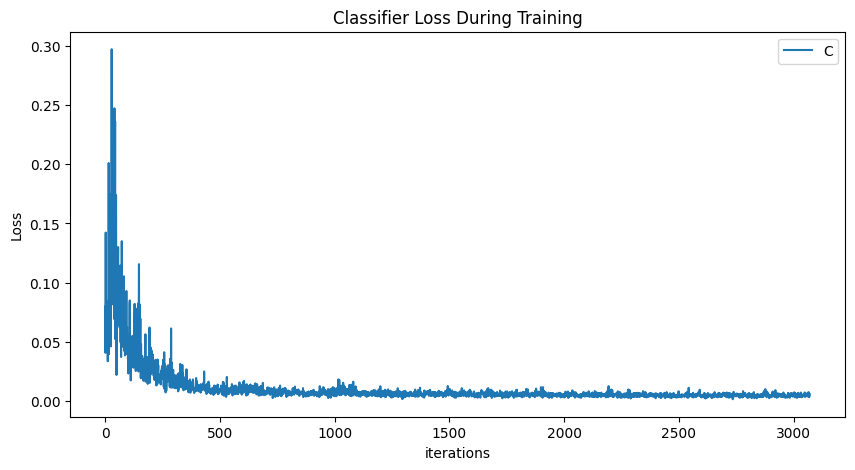

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Classifier Loss During Training")
plt.plot(C_losses,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [ ]:
dataiter = iter(test_loader)
data, labels = next(dataiter)

print(labels)

tensor([[[0.1057]],

        [[0.0489]],

        [[0.0091]],

        [[0.1607]],

        [[0.0098]],

        [[0.0955]],

        [[0.0088]],

        [[0.2027]],

        [[0.2142]],

        [[0.0892]],

        [[0.0056]],

        [[0.1139]],

        [[0.0699]],

        [[0.1423]],

        [[0.0916]],

        [[0.0651]],

        [[0.1023]],

        [[0.0011]],

        [[0.0221]],

        [[0.0004]],

        [[0.0043]],

        [[0.0090]],

        [[0.1128]],

        [[0.1682]],

        [[0.1175]],

        [[0.1478]],

        [[0.0377]],

        [[0.1260]],

        [[0.2008]],

        [[0.1652]],

        [[0.0994]],

        [[0.0865]]])


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1)

        # print(data)
        
        # calculate outputs by running images through the network
        outputs = net(inputs)
        print(outputs)
        print(labels)
        # the class with the highest energy is what we choose as prediction
    

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

tensor([[ 0.0302],
        [ 0.0958],
        [ 0.0955],
        [ 0.0651],
        [ 0.1173],
        [ 0.1008],
        [ 0.0871],
        [ 0.0153],
        [ 0.0714],
        [ 0.0361],
        [ 0.1579],
        [ 0.0737],
        [ 0.0703],
        [ 0.1025],
        [ 0.0693],
        [ 0.0795],
        [ 0.1071],
        [ 0.0324],
        [ 0.0816],
        [ 0.0823],
        [ 0.0077],
        [ 0.0365],
        [ 0.0131],
        [ 0.1518],
        [ 0.0551],
        [-0.0081],
        [ 0.0571],
        [ 0.0657],
        [-0.0067],
        [ 0.1275],
        [ 0.1535],
        [ 0.0648]], device='mps:0')
tensor([[0.1057],
        [0.0489],
        [0.0091],
        [0.1607],
        [0.0098],
        [0.0955],
        [0.0088],
        [0.2027],
        [0.2142],
        [0.0892],
        [0.0056],
        [0.1139],
        [0.0699],
        [0.1423],
        [0.0916],
        [0.0651],
        [0.1023],
        [0.0011],
        [0.0221],
        [0.0004],
        [0.0043

ZeroDivisionError: integer division or modulo by zero

In [ ]:
outputs = net(data)
print(outputs)

TypeError: conv1d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !NoneType!, !tuple of (int,)!, !tuple of (int,)!, !tuple of (int,)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !NoneType!, !tuple of (int,)!, !tuple of (int,)!, !tuple of (int,)!, int)
